In [ ]:
import sys
import os
sys.path.append(os.path.abspath('/home/andyalyfsyah/FLUENT-Chatbot-2023/FLUENT_REFACTORED_24'))

In [25]:
import json
import torch
import torch.nn as nn
import torch.utils.data
import math
import torch.nn.functional as F
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from collections import Counter
from torchinfo import summary
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
from evaluation_tool import calculate_bleu, compute_average_chrf

# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)

def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

pairs = []
max_len = 90

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())

    if len(first) == 0 or len(second) == 0:
        continue

    
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

pairs_df = pd.DataFrame(pairs, columns=['question', 'answer'])

word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

min_word_freq = 0
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

print("Total words are: {}".format(len(word_map)))

with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c


def encode_question_left(words, word_map):
    enc_c = [word_map['<pad>']] * (max_len - len(words)) + [word_map.get(word, word_map['<unk>']) for word in words]
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    # qus = encode_question_left(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)


knowledgebase_url_test = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_eval.xlsx'
knowledgebase_test = pd.read_excel(knowledgebase_url_test)
truncated_real_answers = []
for i in list(knowledgebase_test['Jawaban']):
    cleaned = remove_punc(i)
    splited = cleaned.split()
    truncated_real_answers.append(' '.join(splited[:120]))

truncated_real_train_answers = []
for i in list(knowledgebase['Jawaban']):
    cleaned = remove_punc(i)
    splited = cleaned.split()
    truncated_real_train_answers.append(' '.join(splited[:120]))

real_questions = list(knowledgebase_test['Pertanyaan'])
real_train_questions = list(knowledgebase['Pertanyaan'])

class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at {path}")
    else:
        print(f"Directory already exists at {path}")

class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers_enc, num_layers_dec, word_map, max_len = 50):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.vocab_size = len(word_map)
        self.embed_enc = Embeddings(self.vocab_size, d_model, num_layers = num_layers_enc, max_len = max_len)
        self.embed_dec = Embeddings(self.vocab_size, d_model, num_layers = num_layers_dec, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            src_embeddings = self.embed_enc(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            tgt_embeddings = self.embed_enc(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        print("size of encoded", encoded.size())
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       

class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss

project = "andialifs/fluent-tesis-playground-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

def neptune_init(name="cobain"):
    run = neptune.init_run(
        project=project,
        api_token=api_token,
        name=name
    )
    return run        

def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name = 'experiment_vanilla_16924_Ext1'
# create_directory(directory)

d_model = 512
heads = 4
num_layers_enc = 1
num_layers_dec = 1
epochs = 500

run = neptune_init(name)
param = {
    "encoder_model" : "3_scratch",
    "decoder_model" : "3_scratch",
    "num_pre_token" : 0,
}
run["parameters"] = param

loss_history_vanilla_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers_enc = num_layers_enc, num_layers_dec= num_layers_dec, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)
last_eval_bleu = 0
last_train_bleu = 0
last_train_chrf = 0
last_eval_chrf = 0

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    # if epoch % 10 == 0:
    #     print("Starting Evaluation")
    #     all_generated_response = []
    #     for eval_question in real_questions:
    #         input_eval_question = [word_map.get(word, word_map['<unk>']) for word in eval_question.split()]
    #         question = torch.LongTensor([input_eval_question]).to(device)
    #         question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    #         generated_response = evaluate(transformer, question, question_mask, 90, word_map)
    #         all_generated_response.append(generated_response)
        
    #     bleu_eval_scores = calculate_bleu(all_generated_response, real_questions, truncated_real_answers)
    #     print(f"BLEU Eval Scores: {bleu_eval_scores}")
    #     last_eval_bleu = bleu_eval_scores["4-gram"]

    #     last_eval_chrf = compute_average_chrf(all_generated_response, truncated_real_answers)
    #     print(f"CHRF Eval Scores: {last_eval_chrf}")

    #     all_generated_response = []
    #     for eval_question in real_train_questions:
    #         input_eval_question = [word_map.get(word, word_map['<unk>']) for word in eval_question.split()]
    #         question = torch.LongTensor([input_eval_question]).to(device)
    #         question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    #         generated_response = evaluate(transformer, question, question_mask, 90, word_map)
    #         all_generated_response.append(generated_response)

    #     bleu_train_scores = calculate_bleu(all_generated_response, real_train_questions, truncated_real_train_answers)
    #     print(f"BLEU Train Scores: {bleu_train_scores}")
    #     last_train_bleu = bleu_train_scores["4-gram"]

    #     last_train_chrf = compute_average_chrf(all_generated_response, truncated_real_train_answers)
    #     print(f"CHRF Train Scores: {last_train_chrf}")

    #     for i in range(5):
    #         print(f"Question: {real_questions[i]}")
    #         print(f"Real Answer: {truncated_real_answers[i]}")
    #         print(f"Predicted Answer: {all_generated_response[i]}")
    #         print()

    #     print("Finished Evaluation")

    # run['train/loss'].append(loss_train)
    # run['train/bleu'].append(last_train_bleu)
    # run['train/chrf'].append(last_train_chrf)
    # run['eval/bleu'].append(last_eval_bleu)
    # run['eval/chrf'].append(last_eval_chrf)


# save_dir = directory + '/experiment_' + '.pth.tar'
# parameters = {
#     'd_model': d_model,
#     'heads': heads,
#     'encoder_layers': num_layers_enc,
#     'decoder_layers': num_layers_dec,
#     'model_dir': save_dir,
#     'total_params': summary(transformer).trainable_params
# }
# run['parameters'] = parameters


# state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
# torch.save(state, save_dir)

# print('Model saved at epoch: {} name {}'.format(epoch, save_dir))


Total words are: 440
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/fluent-tesis-playground-24/e/FLUEN-101


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


size of encoded torch.Size([44, 90, 512])
Epoch [0][0/1]	Loss: 4.590
size of encoded torch.Size([44, 90, 512])
Epoch [1][0/1]	Loss: 4.589
size of encoded torch.Size([44, 90, 512])
Epoch [2][0/1]	Loss: 4.596
size of encoded torch.Size([44, 90, 512])
Epoch [3][0/1]	Loss: 4.580
size of encoded torch.Size([44, 90, 512])
Epoch [4][0/1]	Loss: 4.586
size of encoded torch.Size([44, 90, 512])
Epoch [5][0/1]	Loss: 4.564
size of encoded torch.Size([44, 90, 512])
Epoch [6][0/1]	Loss: 4.582
size of encoded torch.Size([44, 90, 512])
Epoch [7][0/1]	Loss: 4.579
size of encoded torch.Size([44, 90, 512])
Epoch [8][0/1]	Loss: 4.577
size of encoded torch.Size([44, 90, 512])
Epoch [9][0/1]	Loss: 4.567
size of encoded torch.Size([44, 90, 512])
Epoch [10][0/1]	Loss: 4.573
size of encoded torch.Size([44, 90, 512])
Epoch [11][0/1]	Loss: 4.565
size of encoded torch.Size([44, 90, 512])
Epoch [12][0/1]	Loss: 4.568
size of encoded torch.Size([44, 90, 512])
Epoch [13][0/1]	Loss: 4.577
size of encoded torch.Size([44

In [3]:
test_question = "apa visi filkom"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> apa visi filkom
A <<< informasi perkembangan produk wisata dapat digunakan untuk meningkatkan daya saing pariwisata dan monorail tourism nasional.wujudan
6.	informatika
7.	informatika
7 6.	informatika
7 7.	informatika
8.	informatika
9.	informatika
10.	informatika
11.	informatika
12.	informatika
13.	informatika
14.	informatika
15.	informatika
16.	informatika
17.	informatika
18.	informatika
19.	informatika
20.	informatika
21.	informatika
22.	informatika
23.	informatika
24.	informatika
25.	informatika
26.	informatika
27.	informatika
28.	informatika
29.	informatika
30.	informatika
31.	informatika
32.	informatika
33.	informatika
34.	informatika
35.	informatika
36.	informatika
37.	informatika
38.	informatika
39.	informatika
40.	informatika
41.	informatika
42.	informatika
43.	informatika
44.	informatika
45.	informatika
46.	informatika
47.	informatika
48.	informatika
49.	informatika
50.	informatika
51.	informatika
52.	informatika
53.	informatika
54.	informatika
55.	informatika
56.	inform

In [ ]:
test_question = "apa email pak fitra"
test_question = [word_map.get(word, word_map['<unk>']) for word in test_question.split()]
test_question = torch.LongTensor([test_question]).to(device)
test_question_mask = (test_question!=0).to(device).unsqueeze(1).unsqueeze(1)
outputs = transformer.encode(test_question, test_question_mask)

TypeError: 'torch.Size' object is not callable

In [26]:
test_question = [
    "apa visi filkom",
    "sebutkan visi filkom",
    "apa visi fakultas",
    "apa misi filkom",
    "sebutkan misi fakultas",
    "apa email pak fitra",
    "email fitra",
    "wd 1 akademik filkom",
    "siapa wd akademik",
    "wd 1 teh saha"
]

labels = ["visi"] * 3 + ["misi"] * 2 + ["email"] * 2 + ["wd_akademik"] * 3

In [27]:
list_encoded = []
for q in test_question:
    q = [word_map.get(word, word_map['<unk>']) for word in q.split()]
    q = torch.LongTensor([q]).to(device)
    q_mask = (q!=0).to(device).unsqueeze(1).unsqueeze(1)
    encoded = transformer.encode(q, q_mask).squeeze(0)
    encoded_mean = torch.mean(encoded, dim=0)
    list_encoded.append(encoded_mean)
list_encoded = torch.stack(list_encoded).detach().cpu().numpy()

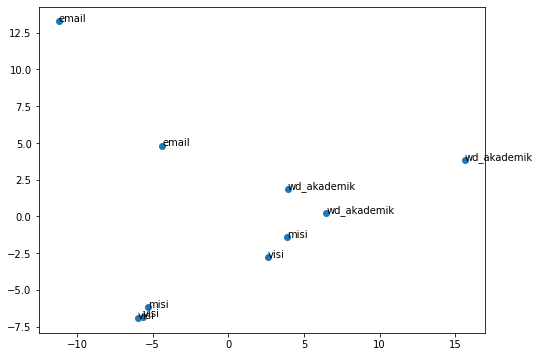

In [28]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
enc_2d = pca.fit_transform(list_encoded)

plt.figure(figsize=(8,6))
plt.scatter(enc_2d[:,0], enc_2d[:,1])
for i, txt in enumerate(labels):
    plt.annotate(txt, (enc_2d[i,0], enc_2d[i,1]))


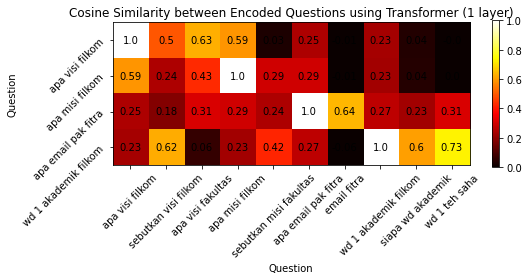

In [29]:
encoded.shape

# for each in encoded, it calculate the distance to the other encoded

from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(list_encoded, list_encoded)

question_train_index = [0,3,5,7]
# delete except question_train_index in columns
cs = cs[question_train_index, :]

# display in a heatmap
plt.figure(figsize=(8,6))
plt.imshow(cs, cmap='hot', interpolation='nearest')
plt.xlabel('Question')
plt.ylabel('Question')
plt.title('Cosine Similarity between Encoded Questions using Transformer (1 layer)')

# make x and y labels
plt.yticks(range(len(question_train_index)), [test_question[i] for i in question_train_index], rotation=45)
plt.xticks(range(len(test_question)), [test_question[i] for i in range(len(test_question))], rotation=45)

# add labels to the heatmap
for i in range(len(test_question)):
    for j in range(len(question_train_index)):
        plt.text(i, j, round(cs[j,i],2), ha='center', va='center', color='black')

plt.colorbar(shrink=0.45)
plt.clim(0,1)

plt.show()